# Aplicação na Área de Saúde

## Análise de Atendimentos Médicos de Emergência com MapReduce 

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.15


Neste Estudo de Caso, vamos analisar dados de serviços de emergência, ocorridos em 2022 na cidade de Santiago no Chile. Os dados são públicos e oferecidos gratuitamente pelo Ministério da Saúde do Chile, no link abaixo.

Variáveis do banco de dados do sistema de Pronto Atendimento

**Ministerio de Salud - Departamento de Estadística e Información de Salud**

https://deis.minsal.cl/

http://www.deis.cl/bases-de-datos-sistema-atenciones-de-urgencia/

Vamos responder à seguinte pergunta:
    
- 1- Qual o total de atendimentos de emergência, para problemas respiratórios, por Hospital, em 2022?  

Obs: Faremos nosso desenvolvimento apenas em Linguagem Python, mas para desenvolver MapReduce para o Hadoop recomendamos o pacote MRJob:

https://mrjob.readthedocs.io/en/latest/

## Carregando os Dados e Compreendendo as Variáveis

In [ ]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Para atualizar a versão do Pandas (descomente a linha abaixo e execute esta célula)
#!pip install -U pandas

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

In [ ]:
# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [ ]:
#!pip install -q pandasql

In [2]:
# Imports para carga e manipulação de dados
import numpy as np
import pandas as pd
import pandasql
import matplotlib.pyplot as plt
import matplotlib as m
%matplotlib inline

# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "MDM" --iversions

Author: MDM

pandas    : 1.4.4
numpy     : 1.24.1
pandasql  : 0.7.3
matplotlib: 3.6.2



In [4]:
# Carregando os dados
dataset = pd.read_csv('dados/urgencias2022.csv', delimiter=';', skiprows=0, low_memory=False, error_bad_lines=False)
dataset.head()

#encoding='latin1',

C:\Users\ferna\AppData\Local\Temp\ipykernel_5544\2872466337.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv('dados/urgencias2022.csv', delimiter=';', skiprows=0, low_memory=False, error_bad_lines=False)


,idestablecimiento,nestablecimiento,Idcausa,glosacausa,TOTAL,MENOR_A_1,Column7,__14,_5_64,_5_MAS,fecha,semana,GLOSATIPOESTABLECIMIENTO,GLOSATIPOATENCION,GlosaTipoCampana
0,02-802,SAPU Cirujano Guzmán ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,1,7,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
1,13-813,SAPU Raúl Cuevas (Ex-San Bernardo),1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,119,1,5,15,83,15,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
2,28-903,SUR Isabel Jiménez,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,0,8,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna
3,26-102,Hospital Dr. Marco Antonio Chamorro ( Porvenir...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,35,1,3,3,27,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
4,16-950,SUR Rauco,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,33,0,2,3,22,6,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna


In [5]:
# Títulos para as colunas
nomes_colunas = ['ID_Estabelecimento', 
                 'Nome_Estabelecimento', 
                 'ID_Causa', 
                 'Global_Causa', 
                 'Total_Pessoas_Atendidas', 
                 'Menores_1_Ano', 
                 '1_4_Anos', 
                 '5_14_Anos', 
                 '15_64_Anos',
                 'Maiores_65_Anos',
                 'Data_Emergencia',
                 'Semana_Estatistica',
                 'Tipo_Estabelecimento',
                 'Tipo_Atencao',
                 'Tipo_Campanha']

In [6]:
# Alterar o nome das colunas
dataset.columns = nomes_colunas

In [7]:
dataset.head()

,ID_Estabelecimento,Nome_Estabelecimento,ID_Causa,Global_Causa,Total_Pessoas_Atendidas,Menores_1_Ano,1_4_Anos,5_14_Anos,15_64_Anos,Maiores_65_Anos,Data_Emergencia,Semana_Estatistica,Tipo_Estabelecimento,Tipo_Atencao,Tipo_Campanha
0,02-802,SAPU Cirujano Guzmán ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,1,7,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
1,13-813,SAPU Raúl Cuevas (Ex-San Bernardo),1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,119,1,5,15,83,15,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
2,28-903,SUR Isabel Jiménez,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,0,8,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna
3,26-102,Hospital Dr. Marco Antonio Chamorro ( Porvenir...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,35,1,3,3,27,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
4,16-950,SUR Rauco,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,33,0,2,3,22,6,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna


In [8]:
dataset.shape

(1048575, 15)

In [9]:
dataset.nunique()

ID_Estabelecimento         638
Nome_Estabelecimento       636
ID_Causa                    12
Global_Causa                12
Total_Pessoas_Atendidas    569
Menores_1_Ano               74
1_4_Anos                   139
5_14_Anos                  217
15_64_Anos                 325
Maiores_65_Anos             93
Data_Emergencia            365
Semana_Estatistica          52
Tipo_Estabelecimento         5
Tipo_Atencao                 3
Tipo_Campanha                6
dtype: int64

In [10]:
dataset.Nome_Estabelecimento.unique()

array(['SAPU Cirujano Guzmán                                                                                ',
       'SAPU Raúl Cuevas (Ex-San Bernardo)', 'SUR Isabel Jiménez',
       'Hospital Dr. Marco Antonio Chamorro ( Porvenir)                                                     ',
       'SUR Rauco', 'SAPU Rosita Renard', 'SAPU Algarrobo',
       'SAPU Padre Las Casas', 'SUR Dr. Raúl Moya', 'SAPU Bellavista',
       'SAPU Trinidad', 'SAPU Nororiente',
       'SAPU-Santa Sabina                                                                                   ',
       'SAPU Pablo Neruda', 'SAPU Valentín Letelier', 'SAPU Marcelo Mena',
       'SAR Las Américas', 'SAPU Curicó Centro', 'SAR Aguas Negras',
       'SAPU Canela',
       'Hospital Dr. Gustavo Fricke (Viña del Mar)                                                          ',
       'SAPU Central Oriente de Antofagasta', 'SAR Puerto Varas',
       'SAPU Los Quillayes',
       'Hospital Del Salvador (Santiago, Providencia) 

In [11]:
# Salvando o DataFrames em Arquivo CSV
file_name = 'dados/urgencias2022-cols.csv'
dataset.to_csv(file_name, encoding = 'utf-8', index = False)

## Trabalhando com Linguagem SQL em Python Dataframes

In [12]:
dataset.query('ID_Causa == 1')

,ID_Estabelecimento,Nome_Estabelecimento,ID_Causa,Global_Causa,Total_Pessoas_Atendidas,Menores_1_Ano,1_4_Anos,5_14_Anos,15_64_Anos,Maiores_65_Anos,Data_Emergencia,Semana_Estatistica,Tipo_Estabelecimento,Tipo_Atencao,Tipo_Campanha
0,02-802,SAPU Cirujano Guzmán ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,1,7,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
1,13-813,SAPU Raúl Cuevas (Ex-San Bernardo),1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,119,1,5,15,83,15,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
2,28-903,SUR Isabel Jiménez,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,0,8,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna
3,26-102,Hospital Dr. Marco Antonio Chamorro ( Porvenir...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,35,1,3,3,27,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
4,16-950,SUR Rauco,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,33,0,2,3,22,6,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712281,21-113,Hospital Dr. Eduardo González Galeno (Cunco) ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,93,0,8,7,64,14,Thu Jan 20 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
712282,13-190,"Hospital Parroquial (Santiago, San Bernardo) ...",1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,45,0,0,0,39,6,Thu Jan 20 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
712283,21-115,Hospital de Carahue ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,67,1,4,7,45,10,Thu Jan 20 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
712396,10-130,Hospital Adalberto Steeger (Talagante),1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,73,1,13,5,39,15,Thu Jan 20 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna


In [13]:
consulta1 = """SELECT * FROM dataset WHERE ID_Causa == 1"""

In [14]:
%%time
print(pandasql.sqldf(consulta1, locals()))

       ID_Estabelecimento                               Nome_Estabelecimento  \
0                  02-802  SAPU Cirujano Guzmán                          ...   
1                  13-813                 SAPU Raúl Cuevas (Ex-San Bernardo)   
2                  28-903                                 SUR Isabel Jiménez   
3                  26-102  Hospital Dr. Marco Antonio Chamorro ( Porvenir...   
4                  16-950                                          SUR Rauco   
...                   ...                                                ...   
203244             21-113  Hospital Dr. Eduardo González Galeno (Cunco)  ...   
203245            13-190   Hospital Parroquial (Santiago, San Bernardo)  ...   
203246             21-115  Hospital de Carahue                           ...   
203247             10-130             Hospital Adalberto Steeger (Talagante)   
203248             15-850                                        SAR Oriente   

        ID_Causa                       

In [15]:
consulta2 = """SELECT Nome_Estabelecimento, SUM(Total_Pessoas_Atendidas) AS TOTAL 
FROM dataset 
WHERE ID_Causa = 1 
GROUP BY Nome_Estabelecimento 
ORDER BY TOTAL DESC"""

In [16]:
%%time
print(pandasql.sqldf(consulta2, locals()))

                                  Nome_Estabelecimento   TOTAL
0    Complejo Hospitalario Dr. Sótero del Río (Sant...  152119
1    Hospital Dr. Félix Bulnes Cerda (Santiago, Qui...  135354
2    Complejo Asistencial  Dr. Víctor Ríos Ruiz (Lo...  116358
3                                      SAPU Miraflores  110662
4    Hospital Dr. Hernán Henríquez Aravena (Temuco)...  109817
..                                                 ...     ...
631                                      SUR Lican Ray       0
632                                       SUR El Álamo       0
633                                    SUR El Colorado       0
634                        SUR Canteras Villa Mercedes       0
635                                      SAPU Quillota       0

[636 rows x 2 columns]
Wall time: 13 s


## Desenvolvendo os Processos de Mapeamento e Redução

Não confunda paradigma de programação MapReduce com o Framework Hadoop MapReduce ou com o Apache Spark.

- **Hadoop MapReduce** - Framework que permite aplicar o paradigma de programação MapReduce em dados distribuídos por diversas máquinas de forma eficiente. Processamento intermediário em disco.


- **Apache Spark** - Framework similar ao Hadoop MapReduce, porém mais fácil de usar, mais amigável e mais veloz (em geral). Processamento intermediário em memória.


- **Paradigma de Programação MapReduce** - Pode ser usado sempre que o tempo de processamento for importante e quando quisermos resumir ou agregar dados para buscar informações específicas.

In [17]:
# Carregando os dados
dataset = pd.read_csv('dados/urgencias2022-cols.csv', low_memory = False)
dataset.head()

,ID_Estabelecimento,Nome_Estabelecimento,ID_Causa,Global_Causa,Total_Pessoas_Atendidas,Menores_1_Ano,1_4_Anos,5_14_Anos,15_64_Anos,Maiores_65_Anos,Data_Emergencia,Semana_Estatistica,Tipo_Estabelecimento,Tipo_Atencao,Tipo_Campanha
0,02-802,SAPU Cirujano Guzmán ...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,1,7,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
1,13-813,SAPU Raúl Cuevas (Ex-San Bernardo),1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,119,1,5,15,83,15,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SAPU,Indiferenciado,Ninguna
2,28-903,SUR Isabel Jiménez,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,9,0,0,0,8,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna
3,26-102,Hospital Dr. Marco Antonio Chamorro ( Porvenir...,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,35,1,3,3,27,1,Sun Jan 16 00:00:00 GMT-04:00 2022,3,Hospital,Indiferenciado,Ninguna
4,16-950,SUR Rauco,1,SECCIÓN 1. TOTAL ATENCIONES DE URGENCIA,33,0,2,3,22,6,Sun Jan 16 00:00:00 GMT-04:00 2022,3,SUR,Indiferenciado,Ninguna


In [18]:
dataset.shape

(1048575, 15)

### Mapeador (Mapper)

In [19]:
%%file mapper.py

# Imports
import csv
import sys
from io import StringIO

# Variável que determina o tipo de causa de atendimento médico de emergência que estamos buscando
ID_CAUSA = '1'

# Loop pelo arquivo de entrada
for line in sys.stdin:
    
    # Separa as linhas
    linha_bytes = line.strip()
    
    # O resultado anterior é em bytes, então convertemos para string
    linha_string = StringIO(linha_bytes)
    
    # Agora separamos as colunas pelo caracter separador vírgula
    colunas_arquivo = csv.reader(linha_string, delimiter = ',')
    
    # Para cada coluna de cada linha...
    for coluna in colunas_arquivo:
        
        # ...checamos a condição de causa (índice 2) e ...
        causa = coluna[2]
        
        # ...se verdadeiro, extraímos as duas colunas que nos interessam 
        # Nome_Estabelecimento (índice 1) e Total_Pessoas_Atendidas (índice 4)
        if causa == ID_CAUSA:
            
            # O resultado é gerado em duas colunas separadas por tab (\t)
            print("%s\t%s" % (coluna[1], coluna[4]))

Overwriting mapper.py


### Redutor (Reducer)

In [20]:
%%file reducer.py

# Imports
import sys
 
# Dicionário para gravar o resultado
resultado = {}

# Função para gravar o resultado no dicionário
def geraResultado(resultado, hospital, total_atendimentos):
    
    # Verifica se o nome do hospital ainda não está na lista de reseultados
    if hospital not in resultado:
        
        # Se não estiver, inclui pela primeira vez
        resultado[hospital] = total_atendimentos
    else:
        # Se já estiver, adiciona ao que já está lá e grava na própria variável
        resultado[hospital] = resultado[hospital] + total_atendimentos

        
# Loop para ler o resultado do processo de mapeamento
for line in sys.stdin:
    
    # Separa as linhas
    linha = line.strip()
    
    # Separa as colunas
    hospital, total_atendimentos = line.split('\t', 1)
    
    # Chama a função de gravação do resultado
    geraResultado(resultado, hospital, int(total_atendimentos))
    
# Imprime o resultado que será gravado em um arquivo txt
# As colunas serão separadas pelo caracter pipe |
for (x, y) in resultado.items():
    print("%s|%s" % (x, y))

Overwriting reducer.py


### Executando o Processo de MapReduce

#### Este é o comando para MacOS ou Linux:

In [ ]:
#%%time
#!cat dados/urgencias2018-cols.csv | python mapper.py | sort | python reducer.py | sort > dados/saida.txt

#### Este é o comando para Windows:

In [21]:
%%time
!type dados\urgencias2022-cols.csv | python mapper.py | sort | python reducer.py | sort > dados\saida.txt

Wall time: 8.73 s


### Apresentação Gráfica do Resultado

In [22]:
# Carregando o arquivo para visualização
nomes_colunas = ['Nome_Hospital', 'Total_Atendimentos']
saida = pd.read_csv('dados/saida.txt', header = None, encoding = 'utf-8', sep = '|')
saida.columns = nomes_colunas
saida.sort_values(by = 'Total_Atendimentos', ascending = False)

,Nome_Hospital,Total_Atendimentos
14,Complejo Hospitalario Dr. Sótero del Río (Sant...,152119
121,"Hospital Dr. Félix Bulnes Cerda (Santiago, Qui...",135354
12,Complejo Asistencial Dr. Víctor Ríos Ruiz (Lo...,116358
344,SAPU Miraflores,110662
124,Hospital Dr. Hernán Henríquez Aravena (Temuco)...,109817
...,...,...
380,SAPU Quillota,0
539,SUR El Álamo,0
587,SUR Peumo,0
514,SUR Canteras Villa Mercedes,0


In [23]:
# Cria dataset com os Top 10 hospitais com mais atendimentos
saida2 = saida.sort_values(by = 'Total_Atendimentos', ascending = False)
saida2 = saida2.head(10)

Text(0.5, 1.0, 'Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022')

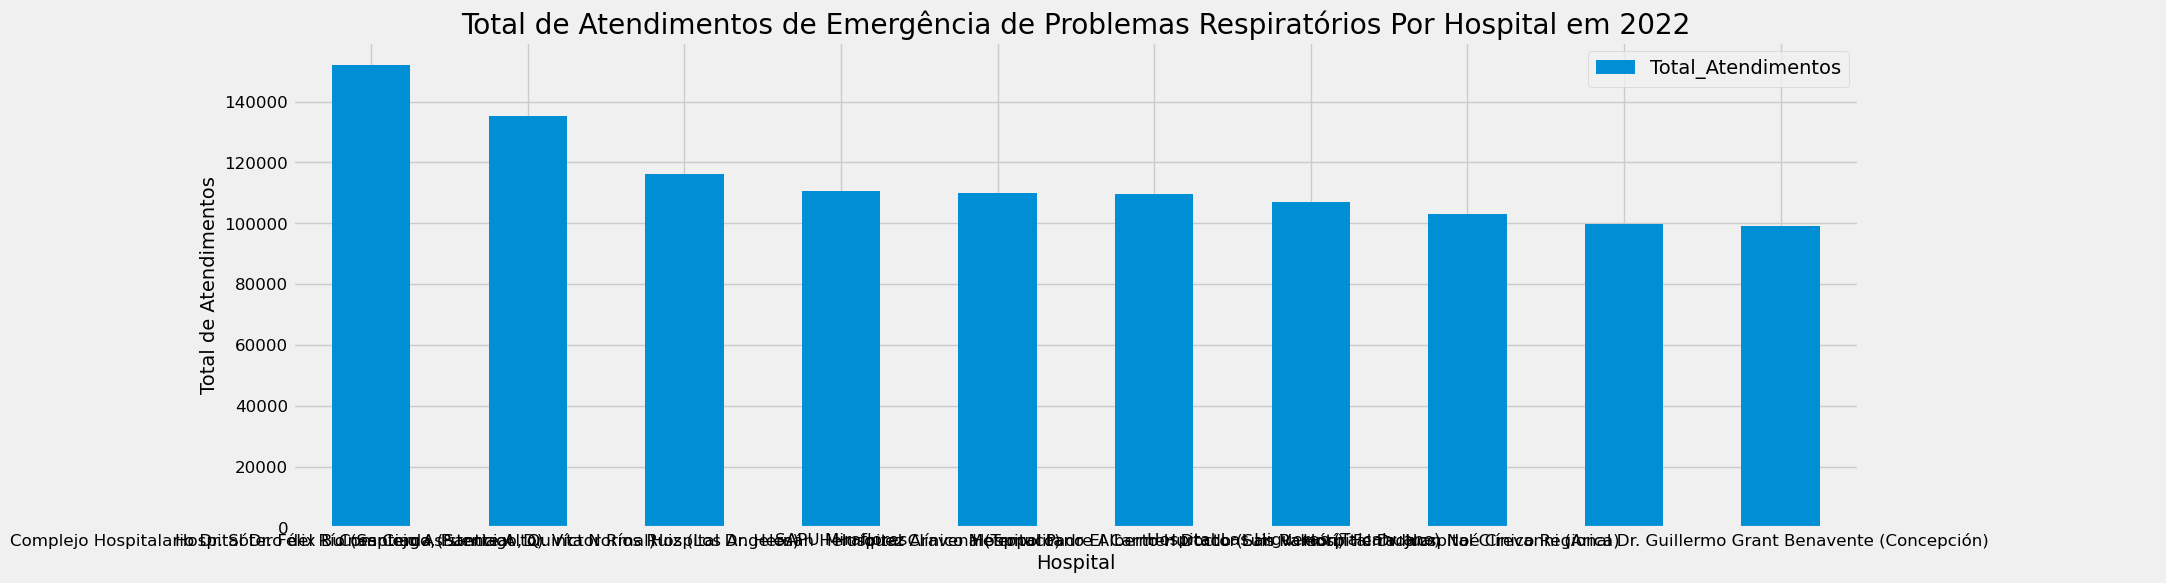

In [24]:
# Gráfico 1
saida2.plot.bar(x = 'Nome_Hospital', y = 'Total_Atendimentos', rot = 0, figsize = (18, 6))
plt.ylabel("Total de Atendimentos")
plt.xlabel("Hospital")
plt.title("Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022")

Text(0.5, 1.0, 'Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022')

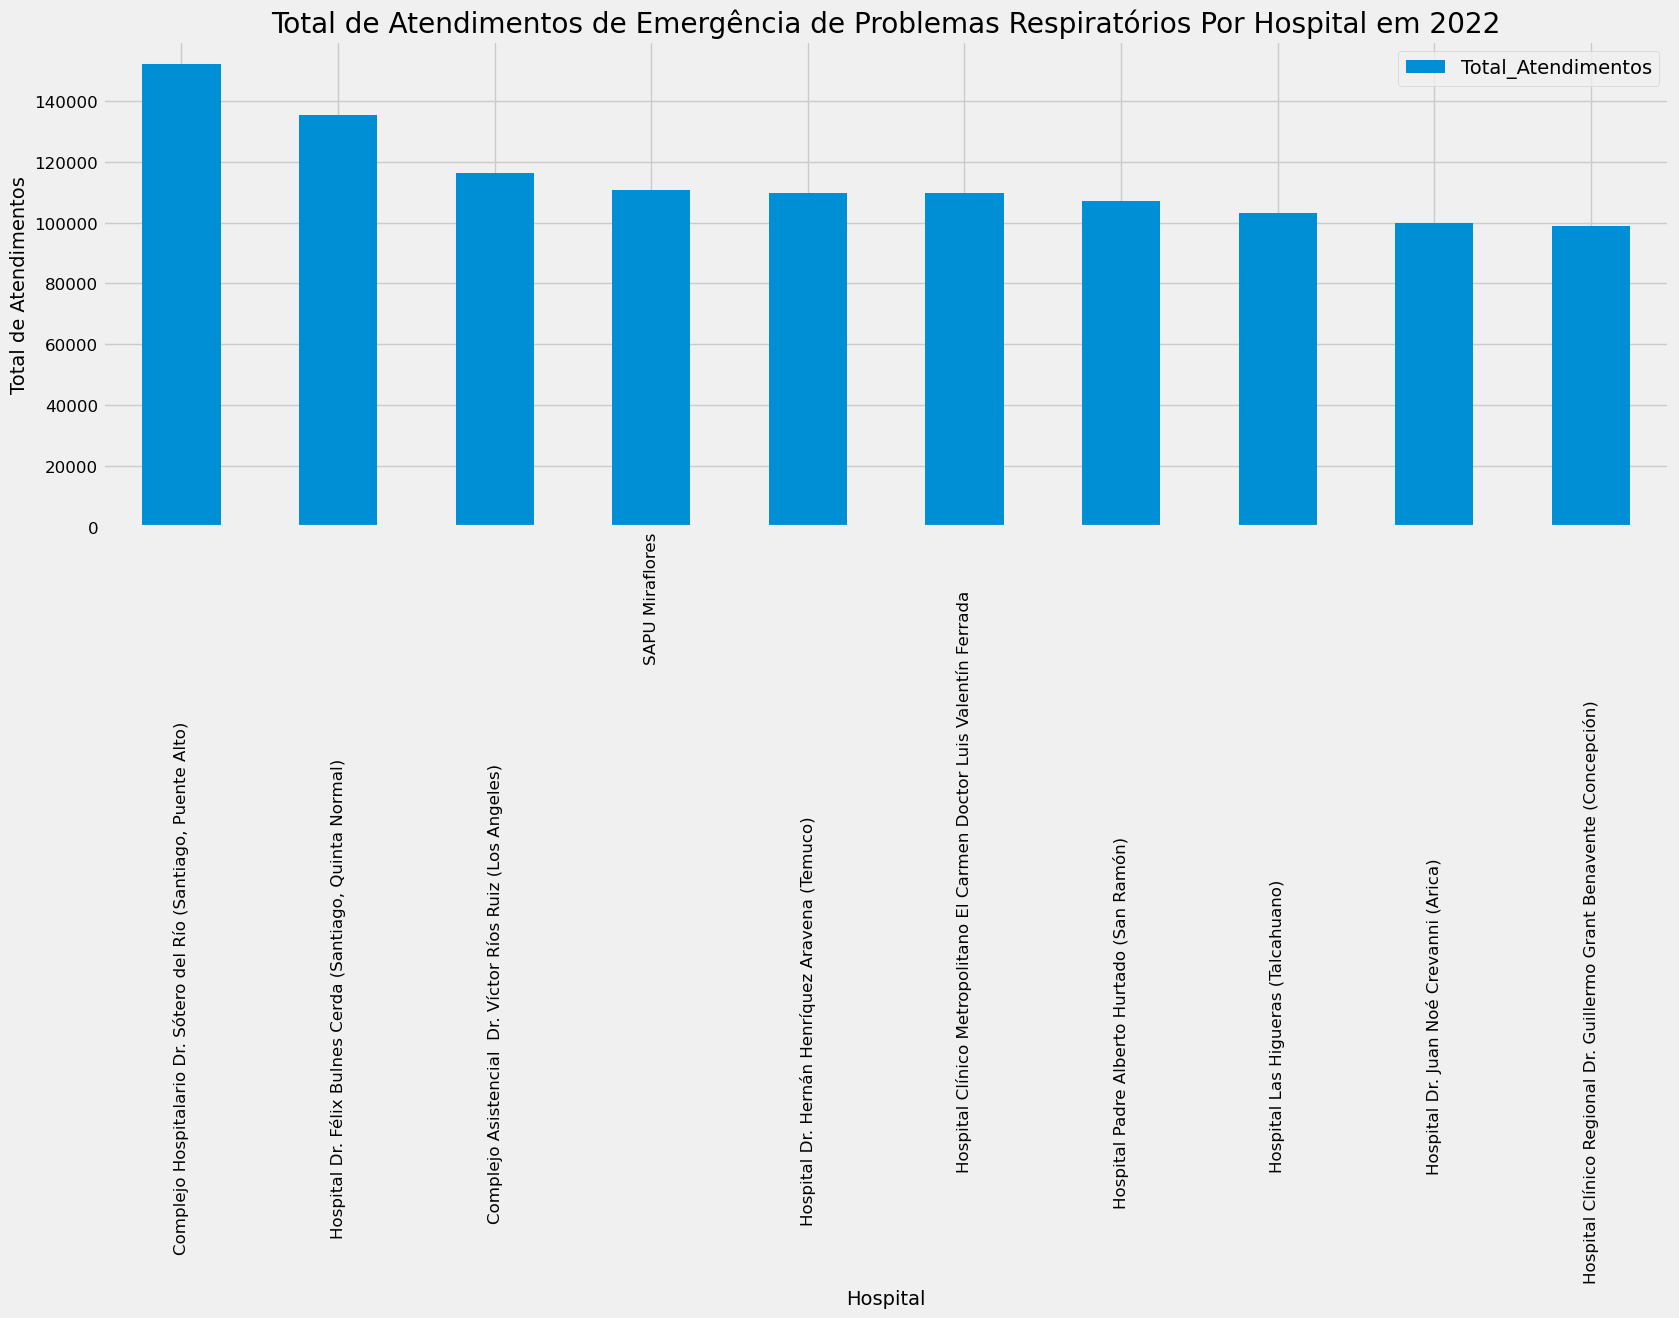

In [25]:
# Gráfico 2
saida2.plot.bar(x = 'Nome_Hospital', y = 'Total_Atendimentos', figsize = (18, 6))
plt.ylabel("Total de Atendimentos")
plt.xlabel("Hospital")
plt.title("Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022")

Text(0.5, 1.0, 'Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022')

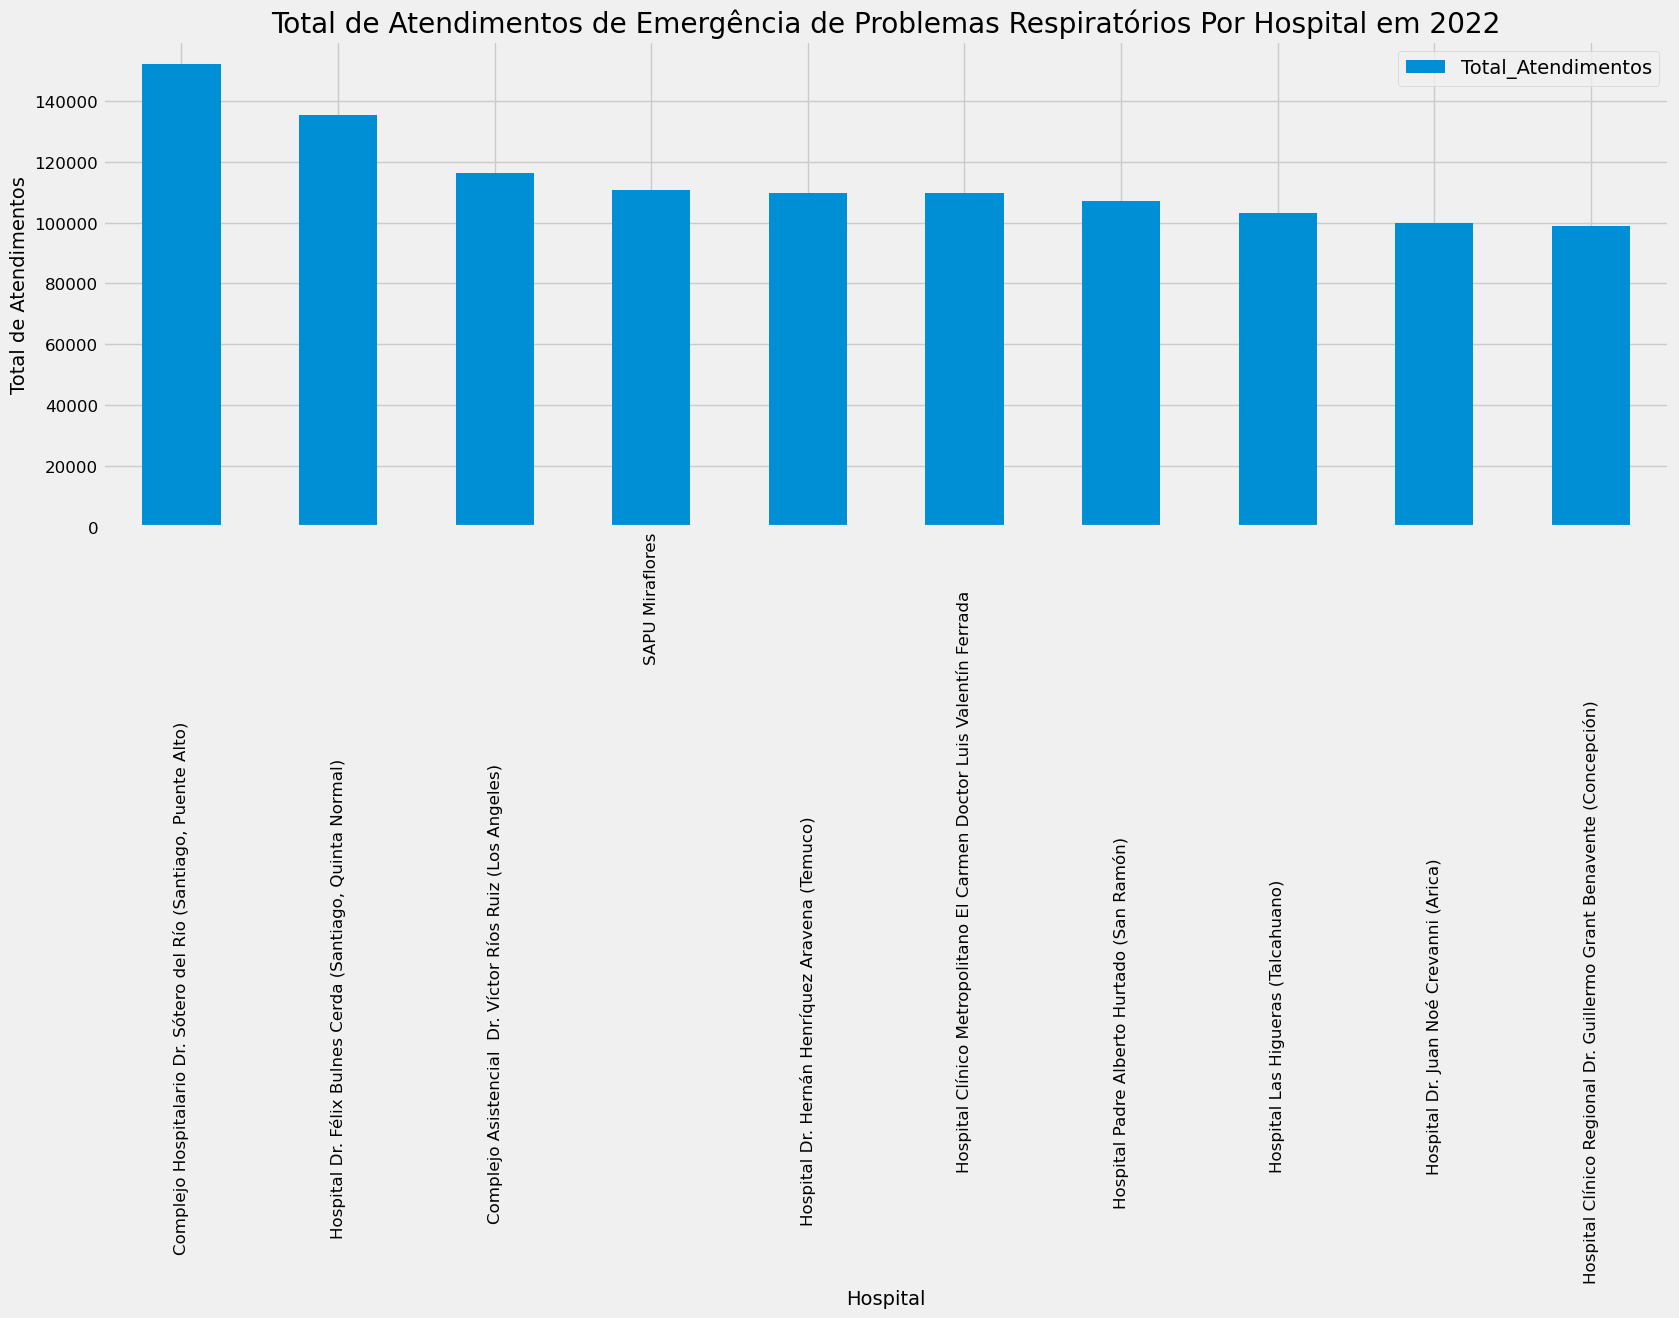

In [26]:
# Gráfico 3
saida2.sort_values(by = 'Total_Atendimentos', ascending = False).plot.bar(x = 'Nome_Hospital', 
                                                                         y = 'Total_Atendimentos', 
                                                                         figsize = (18, 6))
plt.ylabel("Total de Atendimentos")
plt.xlabel("Hospital")
plt.title("Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022")

Text(0.5, 1.0, 'Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022')

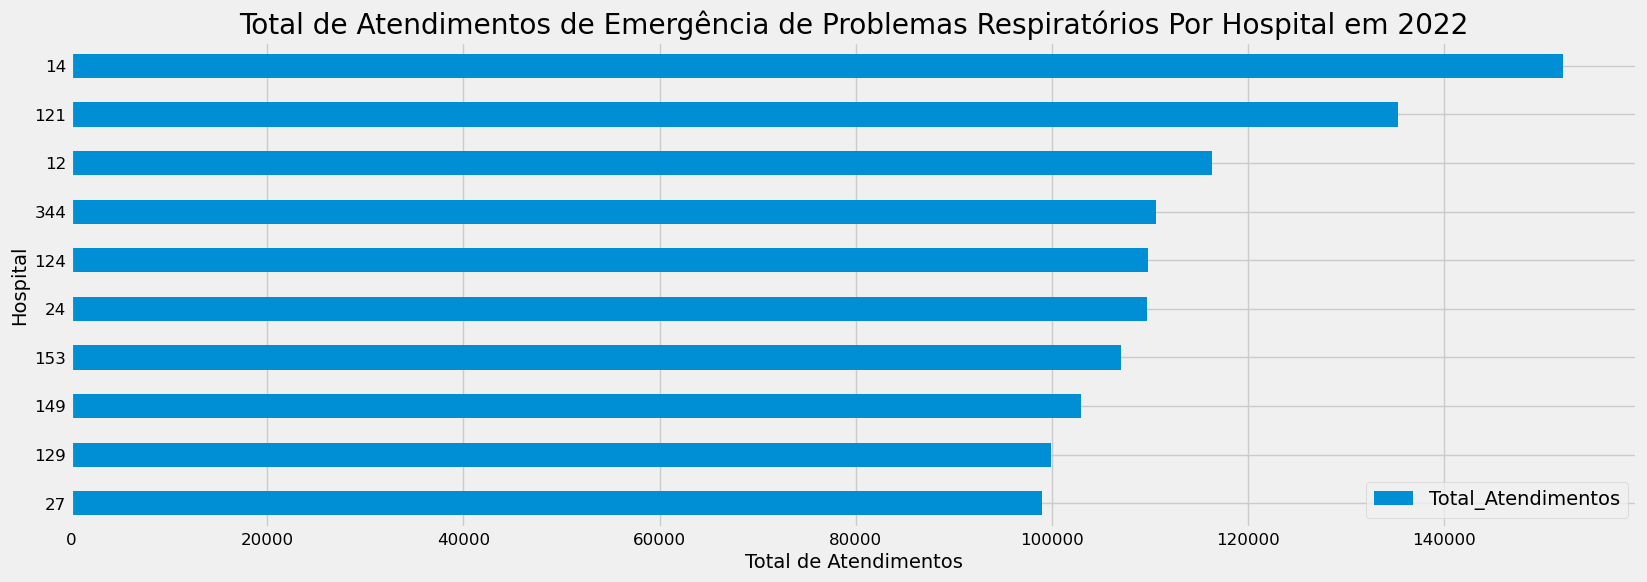

In [27]:
# Gráfiico 4
saida2.sort_values(by = 'Total_Atendimentos', ascending = True).plot(kind = 'barh', figsize = (18, 6))
plt.xlabel("Total de Atendimentos")
plt.ylabel("Hospital")
plt.title("Total de Atendimentos de Emergência de Problemas Respiratórios Por Hospital em 2022")

Observação:
    
A biblioteca PandaSQL cria uma base de dados in-memory utilizando o engine do sqlite e então realiza a consulta sobre esta base. 

O "problema" é que para fazer a consulta na base de dados a biblioteca obviamente precisa fazer a carga dos dados em um dataframe pandas e aí é onde a lentidão se encontra. Considerando somente o SQL da consulta, o tempo de processamento deve ficar abaixo de 30ms. Ainda e mais lento do que o MapReduce, mas é importante que esta observação fique registrada.

# Fim